# Stochastic Coagulation-Fragmentation Dynamics
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\def\Yc{\mathbf{Y}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing
init_printing()

# import functions and classes for compartment models
from compartor import *

## Specifying the reaction network

In [2]:
from coagulation_fragmentation import D, transitions
display_transition_classes(transitions)

Display.__str__: TODO

## Deriving expected moment dynamics

Next we specify the moments we want to derive, for example, $N$, $N^2$, $M^1$, and $(M^1)^2$.

To denote a particular moment, use the `Moment` class. It takes as constructor arguments the integer exponents in each species.

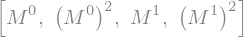

In [3]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2
]
display(moments)

Then call the function `compute_moment_equations()`, giving the reaction network, the desired moment expressions, and the number of species.

In [4]:
(equations, missing) = compute_moment_equations(transitions, moments, D)

The result is a pair `(equations, missing)`.

`equations` are the expressions for the expectation of the desired moment expressions.
`equations` is a list of pairs `(fM, dfMdt)`, where each pair consists of the desired moment expression, and the derived expression for its derivative by $t$.

`missing` is a set of moment expressions that are reuired in the derivatives, but are not known yet (not listed in desired `moments`).

To display the derived equations, use the `display_moment_equations()` function.

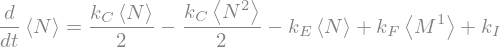

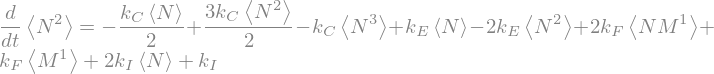

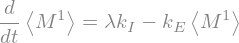

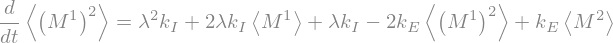

In [5]:
display_moment_equations(equations)

The missing moment expressions occuring in these equations are `missing`.

{Moment(0)**3, Moment(2), Moment(0)*Moment(1)}


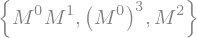

In [6]:
print(missing)
missing

We add the moments below order 3 to the list of moments to derive and iterate the derivation. (We apply gamma closure for 3rd order moments below.)

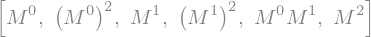

In [7]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2,
    Moment(0)*Moment(1),
    Moment(2)
]
display(moments)

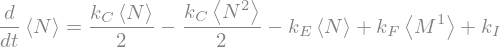

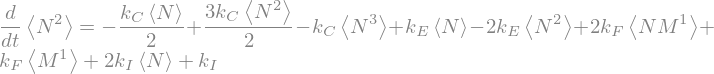

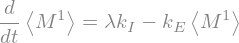

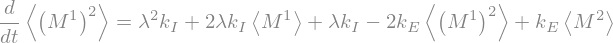

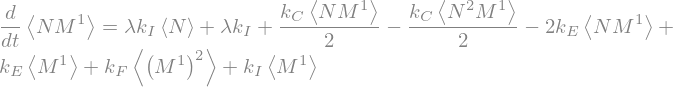

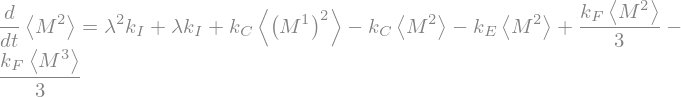

In [8]:
(equations, missing) = compute_moment_equations(transitions, moments, D)
display_moment_equations(equations)

{Moment(0)**3, Moment(3), Moment(0)**2*Moment(1)}


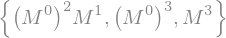

In [9]:
print(missing)
missing

## Gamma closure
Next we compute the Gamma closures for the missing moments.

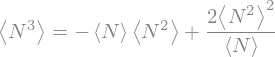

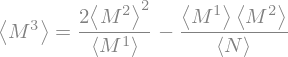

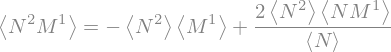

In [10]:
closures = gamma_closures(missing)
display_closures(closures)

We substitute the closures into the moment equations.

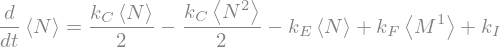

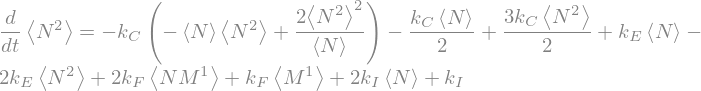

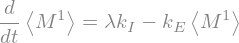

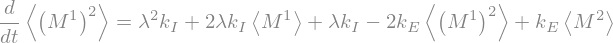

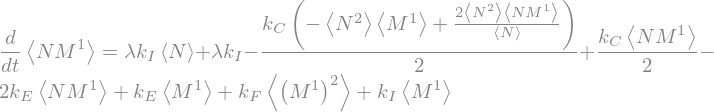

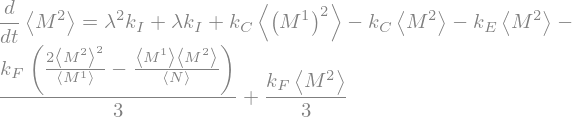

In [11]:
equations = substitute_closures(equations, closures)
display_moment_equations(equations)

## Code generation
From the closed equations, we can generate code for simulating the system.
Currently, Python or Julia code can be generated.
Both derive from a common `AbstractCodeGenerator` class, and it should be relatively straightforward to tweak the code generation for other languages/solvers.

Here, we use the Python generator.

In [12]:
generator = GeneratePython()
code = generator.generate(equations, function_name="coagulation_fragmentation")
#print(code)
exec(code) # execute generated code

This creates code for two functions, `coagulation_fragmentation_ODEs` and `coagulation_fragmentation_initial`.
The arguments to the functions are listed in the doc strings:

In [13]:
help(coagulation_fragmentation_initial)
help(coagulation_fragmentation_ODEs)

Help on function coagulation_fragmentation_initial in module __main__:

coagulation_fragmentation_initial(initial)
    Create inital expected moments vector
    
    :param initial: tuple of initial values for expectations of (Moment(0,), Moment(1,), Moment(2,))
    :return: initial expected moments vector

Help on function coagulation_fragmentation_ODEs in module __main__:

coagulation_fragmentation_ODEs(M, dM, parameters)
    Evaluate derivatives of expected moments
    
    Indices in M and dM vectors are 
      M[0] = Moment(0,)
      M[1] = Moment(0)**2
      M[2] = Moment(1,)
      M[3] = Moment(1)**2
      M[4] = Moment(0)*Moment(1)
      M[5] = Moment(2,)
    
    :param M: expected moments
    :param dM: result, the derivative dM/dt is stored here
    :param parameters: tuple of values for constants (\lambda, k_C, k_E, k_F, k_I)
    :return: dM



## Solving and plotting results
We use the generated functions with `scipy.solve_ivp` to solve the system.

In [14]:
from scipy.integrate import solve_ivp
import numpy as np

# vector of timepoints where to solve ODE problem
timepoints = np.linspace(0, 100, 1001)

# initial condition
# 100 compartments with 10 molecules each
M0 = coagulation_fragmentation_initial((100, 1000, 10000))

# rate constants and other parameters
kC = 0.005
kF = 0.005
kI = 10.0
kE = 0.1
Lambda = 50
parameters = (Lambda, kC, kE, kF, kI)

# solve
sol = solve_ivp(
    lambda t, M: coagulation_fragmentation_ODEs(M, np.zeros(6), parameters),
    (np.min(timepoints), np.max(timepoints)),
    M0,
    method='BDF',
    t_eval=timepoints)

# print solution of N
print(sol.y[0])

[100.          98.09964031  96.31871186 ... 100.04489169 100.04479285
 100.04470542]


Finally, we use `matplotlib` to plot the solution for mean and standard deviation of $N$.

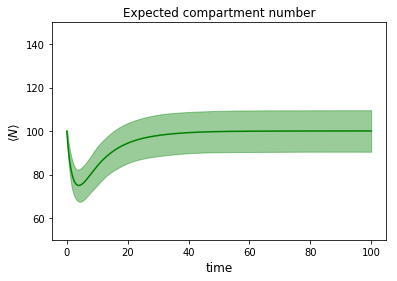

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

y = sol.y
N = y[0]
stdN = np.sqrt(y[1] - N**2)
plt.plot(timepoints, y[0], color="g")
plt.ylabel(r'$\left< N \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected compartment number", size=12)
plt.fill_between(timepoints, N-stdN, N+stdN, alpha=0.4, color="g")
plt.ylim((50,150))